# Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from config import *

from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential

from sklearn.model_selection import train_test_split

# Read data

In [12]:
data_dir = '../data'
files = os.listdir(data_dir)

classes = []
for path in files:
    classes.append(path.split('.')[0])
list.sort(classes)


df = {}
for className in classes:
    df[className] = pd.read_csv(os.path.join(data_dir,className+".csv"))

print("Classes: {}".format(classes))
print(df[classes[0]].head(3))

Classes: ['Nod_head', 'Swing_hand']
          0         1         2         3         4         5         6  \
0  0.556895  0.557111 -1.274520  0.999868  0.594925  0.477804 -1.205467   
1  0.548052  0.568032 -1.272724  0.999861  0.586772  0.487091 -1.210947   
2  0.539867  0.573619 -1.332037  0.999856  0.579916  0.490168 -1.285937   

          7         8         9  ...       122       123       124       125  \
0  0.999792  0.616753  0.476875  ...  0.984213  0.000015  0.708581  3.222181   
1  0.999775  0.608110  0.486257  ...  0.992125  0.000015  0.701866  3.202845   
2  0.999762  0.601918  0.489280  ...  1.322206  0.000016  0.701669  3.201613   

        126       127       128       129       130       131  
0  0.291900  0.000062  0.499230  3.212415  0.171246  0.000054  
1  0.145340  0.000063  0.500012  3.201835  0.219709  0.000055  
2  0.210095  0.000062  0.504857  3.201983  0.530774  0.000056  

[3 rows x 132 columns]


# Create train X, Y

In [13]:
nClass = len(classes)

X = []
y = []

for idx, className in enumerate(classes):
    nSample = len(df[className])
    for start in range(nSample-N_TIME):
        X.append(df[className].iloc[start:start+N_TIME,:])
        one_hot = [0]*nClass
        one_hot[idx] = 1
        y.append(one_hot)

X, y = np.array(X), np.array(y)

print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))

X shape: (1180, 10, 132)
y shape: (1180, 2)


# Train test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print("[Train]")
print("X shape: {}".format(X_train.shape))
print("y shape: {}".format(y_train.shape))

print("[Test]")
print("X shape: {}".format(X_test.shape))
print("y shape: {}".format(y_test.shape))

[Train]
X shape: (944, 10, 132)
y shape: (944, 2)
[Test]
X shape: (236, 10, 132)
y shape: (236, 2)


# Modeling

In [15]:
model = Sequential([
    LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units = 50, return_sequences = True),
    Dropout(0.2),
    LSTM(units = 50, return_sequences = True),
    Dropout(0.2),
    LSTM(units = 50),
    Dropout(0.2),
    Dense(units = len(classes), activation='softmax')
])

model.compile(
    optimizer = 'adam',
    metrics = ['accuracy'],
    loss = 'categorical_crossentropy'
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 50)            36600     
                                                                 
 dropout_4 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_5 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_6 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

# Training process

In [16]:
trainingRet = model.fit(
    X_train, 
    y_train,
    epochs = N_EPOCH,
    batch_size = BATCH_SIZE,
    validation_data=(X_test, y_test)
)

model.save('../models/best.h5')

Epoch 1/32
15/15 [==============================] - 7s 111ms/step - loss: 0.4089 - accuracy: 0.8941 - val_loss: 0.0932 - val_accuracy: 0.9788
Epoch 2/32
15/15 [==============================] - 0s 23ms/step - loss: 0.0912 - accuracy: 0.9735 - val_loss: 0.1154 - val_accuracy: 0.9746
Epoch 3/32
15/15 [==============================] - 0s 24ms/step - loss: 0.0769 - accuracy: 0.9788 - val_loss: 0.1036 - val_accuracy: 0.9746
Epoch 4/32
15/15 [==============================] - 0s 19ms/step - loss: 0.0532 - accuracy: 0.9883 - val_loss: 0.0821 - val_accuracy: 0.9788
Epoch 5/32
15/15 [==============================] - 0s 22ms/step - loss: 0.0490 - accuracy: 0.9894 - val_loss: 0.0624 - val_accuracy: 0.9831
Epoch 6/32
15/15 [==============================] - 0s 23ms/step - loss: 0.0409 - accuracy: 0.9862 - val_loss: 0.0290 - val_accuracy: 0.9831
Epoch 7/32
15/15 [==============================] - 0s 23ms/step - loss: 0.0314 - accuracy: 0.9915 - val_loss: 0.0737 - val_accuracy: 0.9831
Epoch 8/32
1

# Plot result

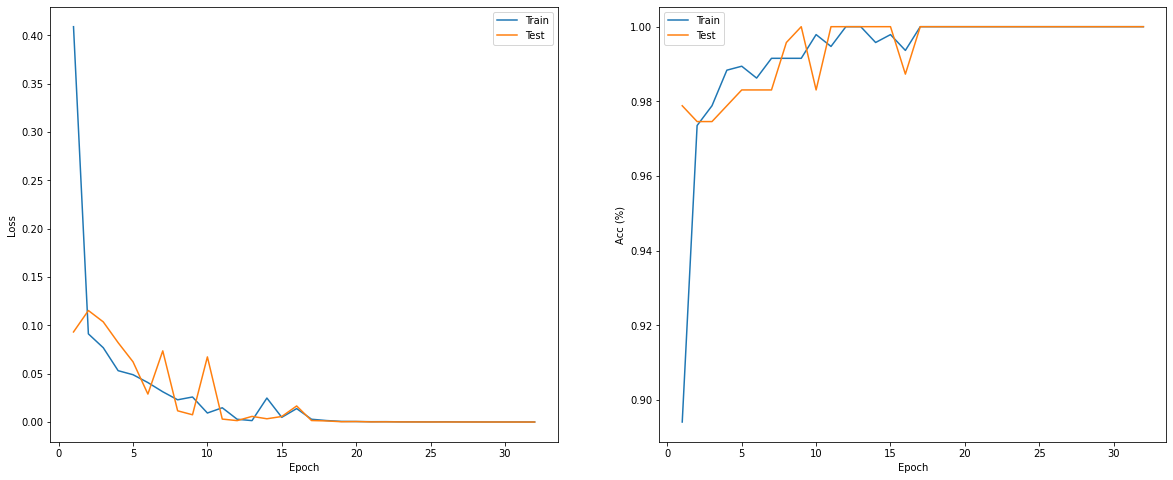

In [17]:
hist = trainingRet.history

fig, ax = plt.subplots(1, 2, figsize=(20,8))
epochs = range(1,N_EPOCH+1)

ax[0].plot(epochs,hist['loss'])
ax[0].plot(epochs,hist['val_loss'])
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train','Test'])

ax[1].plot(epochs,hist['accuracy'])
ax[1].plot(epochs,hist['val_accuracy'])
ax[1].set_ylabel('Acc (%)')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train','Test'])

plt.show()